In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the full dataset
data = pd.read_csv('../../data/curated/FINAL_COMPLETE_DATASET_no_poly.csv')

# Load the shapefile
gdf_shapefile = gpd.read_file('../../data/raw/SAL_2021_AUST_GDA2020.shp')

# Clean up the suburb columns for consistency
data['SAL_suburb'] = data['SAL_suburb'].str.strip().str.lower()
gdf_shapefile['SAL_NAME21'] = gdf_shapefile['SAL_NAME21'].str.strip().str.lower()

# Merge the shapefile with the dataset on the suburb name
combined_gdf = gdf_shapefile.merge(data, left_on='SAL_NAME21', right_on='SAL_suburb')

combined_gdf.head()


,SAL_CODE21,SAL_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21_x,LOCI_URI21,SHAPE_Leng,SHAPE_Area,...,healthcare,industrial,public_transport,recreation,residential,shopping,inflation,2024_average_baths,2024_average_parking,2024_property_count
0,20003,aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,...,0.0,0.0,0.0,11.0,0.0,1.0,1.3,NaN,NaN,NaN
1,20003,aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,...,0.0,0.0,0.0,11.0,0.0,1.0,2.1,NaN,NaN,NaN
2,20003,aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,...,0.0,0.0,0.0,11.0,0.0,1.0,1.9,NaN,NaN,NaN
3,20003,aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,...,0.0,0.0,0.0,11.0,2.0,1.0,1.3,NaN,NaN,NaN
4,20003,aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,...,0.0,0.0,0.0,10.0,2.0,1.0,2.2,NaN,NaN,NaN


In [23]:
combined_gdf.columns

Index(['SAL_CODE21', 'SAL_NAME21', 'STE_CODE21', 'STE_NAME21', 'AUS_CODE21',
       'AUS_NAME21', 'AREASQKM21_x', 'LOCI_URI21', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry', 'Suburb Cluster', 'SAL_suburb', 'SAL_CODE', 'Suburb Group',
       'AREASQKM21_y', 'station_count_in_suburb', 'closest_stations',
       'closest_station_1_STOP_NAME', 'closest_station_1_LATITUDE',
       'closest_station_1_LONGITUDE', 'closest_station_2_STOP_NAME',
       'closest_station_2_LATITUDE', 'closest_station_2_LONGITUDE',
       'suburb_centre_latitude', 'suburb_centre_longitude', 'distance_to_CBD',
       'time_to_CBD', 'distance_to_station', 'time_to_station', 'median_score',
       'average_price', 'proximity_to_beach', 'Cemeteries',
       'Civic squares and promenades', 'Conservation reserves',
       'Government schools', 'Natural and semi-natural open space',
       'Non-government schools', 'Parks and gardens',
       'Public housing reserves', 'Recreation corridor',
       'Services and utiliti

In [24]:
# Filter for the year
year = 2024
combined_gdf_year = combined_gdf[combined_gdf['year'] == year].copy()  # Ensure we are working on a copy

# Initialize the MinMaxScaler for normalization
scaler = MinMaxScaler()

# Define the weights (initially set to 1, can be modified as needed)
weights = {
    'stability': 1,
    'healthcare': 1,
    'culture': 1,
    'education': 1,
    'infrastructure': 1
}

# 1. Stability (Inverted, as lower crime rates are better for stability)
stability_columns = [
    'A Crimes against the person', 'B Property and deception offences',
    'C Drug offences', 'D Public order and security offences',
    'E Justice procedures offences', 'F Other offences'
]
combined_gdf_year.loc[:, 'stability_score'] = 1 - scaler.fit_transform(combined_gdf_year[stability_columns].mean(axis=1).values.reshape(-1, 1))

# 2. Healthcare
combined_gdf_year.loc[:, 'healthcare_score'] = scaler.fit_transform(combined_gdf_year[['healthcare']])

# 3. Culture & Environment
culture_columns = [
    'proximity_to_beach', 'Parks and gardens', 'Natural and semi-natural open space',
    'Civic squares and promenades', 'Recreation corridor', 'Conservation reserves'
]
combined_gdf_year.loc[:, 'culture_score'] = scaler.fit_transform(combined_gdf_year[culture_columns].mean(axis=1).values.reshape(-1, 1))

# 4. Education
education_columns = ['Government schools', 'Non-government schools', 'Tertiary institutions']
combined_gdf_year.loc[:, 'education_score'] = scaler.fit_transform(combined_gdf_year[education_columns].mean(axis=1).values.reshape(-1, 1))

# 5. Infrastructure
infrastructure_columns = ['station_count_in_suburb', 'public_transport', 'shopping', 'recreation']
combined_gdf_year.loc[:, 'infrastructure_score'] = scaler.fit_transform(combined_gdf_year[infrastructure_columns].mean(axis=1).values.reshape(-1, 1))

# Calculate the overall livability score as a weighted average of the normalized scores
combined_gdf_year['livability_score'] = (
    combined_gdf_year['stability_score'] * weights['stability'] +
    combined_gdf_year['healthcare_score'] * weights['healthcare'] +
    combined_gdf_year['culture_score'] * weights['culture'] +
    combined_gdf_year['education_score'] * weights['education'] +
    combined_gdf_year['infrastructure_score'] * weights['infrastructure']
) / sum(weights.values())  # Divide by the total of the weights

# Display the top suburbs by livability score
top_suburbs = combined_gdf_year[['SAL_suburb', 'livability_score']].sort_values(by='livability_score', ascending=False)

# Output the top suburbs by livability score
top_suburbs.head(10)


,SAL_suburb,livability_score
2075,frankston,0.500541
528,berwick,0.490194
2062,footscray,0.468726
1490,dandenong,0.442754
2244,glen waverley,0.438724
1724,doreen,0.406918
4233,point cook,0.366825
1334,craigieburn,0.358389
4454,rowville,0.358091
1243,coburg,0.357588


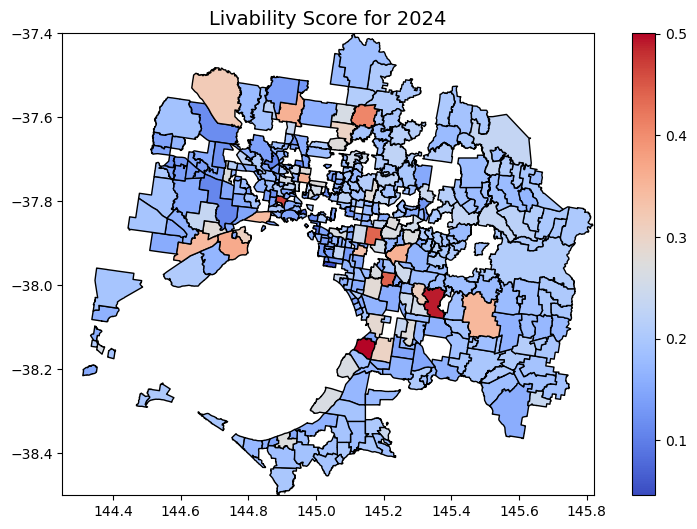

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the livability score using a color map
combined_gdf_year.plot(column='livability_score', ax=ax, legend=True,
                       cmap='coolwarm', edgecolor='black')

# Set the title and labels
ax.set_title('Livability Score for 2024', fontsize=14)

# Set the limits for the plot to zoom in on the greater melbourne
ax.set_xlim([144.25, 145.82])  # Longitude limits
ax.set_ylim([-38.5, -37.4])  # Latitude limits

# Save the plot as a PNG file
plt.savefig('../../plots/livability_2024.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



In [26]:
# Filter for 2023 and 2024 data
data_2023 = combined_gdf[combined_gdf['year'] == 2023].copy()
data_2024 = combined_gdf[combined_gdf['year'] == 2024].copy()

# Merge 2023 and 2024 data on suburb to compare rents
merged_data = data_2024[['SAL_suburb', 'average_weekly_rent']].merge(
    data_2023[['SAL_suburb', 'average_weekly_rent']],
    on='SAL_suburb',
    suffixes=('_2024', '_2023')
)

# Calculate the percentage change in rent from 2023 to 2024
merged_data['rent_change_pct'] = ((merged_data['average_weekly_rent_2024'] - merged_data['average_weekly_rent_2023']) / merged_data['average_weekly_rent_2023']) * 100

# Filter out the suburbs where rent decreased by more than 10%
filtered_data = merged_data[merged_data['rent_change_pct'] >= -10]

# Merge this filtered data with the 2024 household income data
filtered_data = filtered_data.merge(
    data_2024[['SAL_suburb', 'Median_tot_hhd_inc_weekly']],
    on='SAL_suburb'
)

# Calculate the Rent-to-Income Ratio (Affordability)
filtered_data['rent_to_income_ratio'] = (filtered_data['average_weekly_rent_2024'] / filtered_data['Median_tot_hhd_inc_weekly']) * 100

# Sort suburbs by affordability (lower ratio = more affordable)
affordable_suburbs = filtered_data.sort_values(by='rent_to_income_ratio')

# Display the top affordable suburbs
affordable_suburbs[['SAL_suburb', 'rent_to_income_ratio']].head(10)


,SAL_suburb,rent_to_income_ratio
329,quandong,6.118421
242,mambourin,12.816607
238,lysterfield south,13.178250
446,yering,14.433347
179,guys hill,14.909418
232,langwarrin south,15.274314
379,tarrawarra,15.833808
255,merricks,15.877863
314,pakenham upper,16.401285
237,lysterfield,16.633400


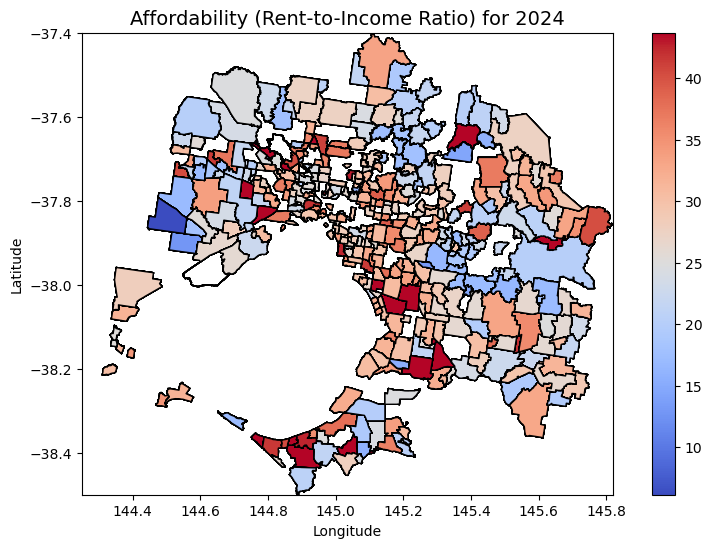

In [27]:
# Ensure Rent-to-Income Ratio is positive and exclude any extreme values
filtered_data['rent_to_income_ratio'] = filtered_data['rent_to_income_ratio'].clip(lower=0)

# Merge the filtered data with geometry from combined_gdf to create a GeoDataFrame for plotting
affordability_gdf = combined_gdf.merge(
    filtered_data[['SAL_suburb', 'rent_to_income_ratio']],
    on='SAL_suburb'
)

# Set reasonable range limits for the color scale
vmin = affordability_gdf['rent_to_income_ratio'].min()
vmax = affordability_gdf['rent_to_income_ratio'].quantile(0.95)  # Cap at the 95th percentile to avoid outliers

# Plot the affordability scores on the map with better scaling
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot with adjusted color scale
affordability_gdf.plot(column='rent_to_income_ratio', ax=ax, legend=True,
                       cmap='coolwarm', edgecolor='black', vmin=vmin, vmax=vmax)

# Set the title and labels
ax.set_title('Affordability (Rent-to-Income Ratio) for 2024', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the limits for the plot to zoom in on the central region
ax.set_xlim([144.25, 145.82])  # Longitude limits
ax.set_ylim([-38.5, -37.4])  # Latitude limits

# Save the plot as a PNG file
plt.savefig('../../plots/affordability_2024.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



In [28]:
# Affordability Calculation

# Filter for 2023 and 2024 data
data_2023 = combined_gdf[combined_gdf['year'] == 2023].copy()
data_2024 = combined_gdf[combined_gdf['year'] == 2024].copy()

# Merge 2023 and 2024 data on suburb to compare rents
merged_data = data_2024[['SAL_suburb', 'average_weekly_rent']].merge(
    data_2023[['SAL_suburb', 'average_weekly_rent']],
    on='SAL_suburb',
    suffixes=('_2024', '_2023')
)

# Calculate the percentage change in rent from 2023 to 2024
merged_data['rent_change_pct'] = ((merged_data['average_weekly_rent_2024'] - merged_data['average_weekly_rent_2023']) / merged_data['average_weekly_rent_2023']) * 100

# Filter out the suburbs where rent decreased by more than 10%
filtered_data = merged_data[merged_data['rent_change_pct'] >= -10]

# Merge this filtered data with the 2024 household income data
filtered_data = filtered_data.merge(
    data_2024[['SAL_suburb', 'Median_tot_hhd_inc_weekly']],
    on='SAL_suburb'
)

# Calculate the Rent-to-Income Ratio (Affordability)
filtered_data['rent_to_income_ratio'] = (filtered_data['average_weekly_rent_2024'] / filtered_data['Median_tot_hhd_inc_weekly']) * 100

# Handle any infinite or NaN values in affordability calculation
filtered_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
filtered_data.dropna(subset=['rent_to_income_ratio'], inplace=True)  # Drop rows with NaN

# Normalize affordability score (lower rent_to_income_ratio is better, so we invert the score)
scaler = MinMaxScaler()
filtered_data['affordability_score'] = 1 - scaler.fit_transform(filtered_data[['rent_to_income_ratio']])

# Livability Calculation

# Initialize the MinMaxScaler for normalization
weights = {
    'stability': 1,
    'healthcare': 1,
    'culture': 1,
    'education': 1,
    'infrastructure': 1
}

# Normalize and calculate livability scores for 2024
combined_gdf_year = combined_gdf[combined_gdf['year'] == 2024].copy()

# 1. Stability (Inverted, as lower crime rates are better for stability)
stability_columns = [
    'A Crimes against the person', 'B Property and deception offences',
    'C Drug offences', 'D Public order and security offences',
    'E Justice procedures offences', 'F Other offences'
]
combined_gdf_year['stability_score'] = 1 - scaler.fit_transform(combined_gdf_year[stability_columns].mean(axis=1).values.reshape(-1, 1))

# 2. Healthcare
combined_gdf_year['healthcare_score'] = scaler.fit_transform(combined_gdf_year[['healthcare']])

# 3. Culture & Environment
culture_columns = [
    'proximity_to_beach', 'Parks and gardens', 'Natural and semi-natural open space',
    'Civic squares and promenades', 'Recreation corridor', 'Conservation reserves'
]
combined_gdf_year['culture_score'] = scaler.fit_transform(combined_gdf_year[culture_columns].mean(axis=1).values.reshape(-1, 1))

# 4. Education
education_columns = ['Government schools', 'Non-government schools', 'Tertiary institutions']
combined_gdf_year['education_score'] = scaler.fit_transform(combined_gdf_year[education_columns].mean(axis=1).values.reshape(-1, 1))

# 5. Infrastructure
infrastructure_columns = ['station_count_in_suburb', 'public_transport', 'shopping', 'recreation']
combined_gdf_year['infrastructure_score'] = scaler.fit_transform(combined_gdf_year[infrastructure_columns].mean(axis=1).values.reshape(-1, 1))

# Handle any infinite or NaN values in livability calculation
combined_gdf_year.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinite values with NaN
combined_gdf_year.dropna(subset=['stability_score', 'healthcare_score', 'culture_score', 'education_score', 'infrastructure_score'], inplace=True)

# Calculate the overall livability score as a weighted average of the normalized scores
combined_gdf_year['livability_score'] = (
    combined_gdf_year['stability_score'] * weights['stability'] +
    combined_gdf_year['healthcare_score'] * weights['healthcare'] +
    combined_gdf_year['culture_score'] * weights['culture'] +
    combined_gdf_year['education_score'] * weights['education'] +
    combined_gdf_year['infrastructure_score'] * weights['infrastructure']
) / sum(weights.values())

# Combine Affordability and Livability

# Merge the affordability and livability data on suburb
combined_data = filtered_data[['SAL_suburb', 'affordability_score']].merge(
    combined_gdf_year[['SAL_suburb', 'livability_score']],
    on='SAL_suburb'
)

# Adjust the weights based on preference
weight_affordability = 0.4  # Give more weight to affordability
weight_livability = 0.6     # Give less weight to livability

# Recalculate the combined score with adjusted weights
combined_data['combined_score'] = (
    (combined_data['affordability_score'] * weight_affordability) +
    (combined_data['livability_score'] * weight_livability)
)

# Sort by combined score
combined_data = combined_data.sort_values(by='combined_score', ascending=False)

# Display the top suburbs with both affordability and livability
combined_data[['SAL_suburb', 'combined_score']].head(10)


,SAL_suburb,combined_score
40,berwick,0.614360
156,footscray,0.608463
157,frankston,0.602983
131,doreen,0.562104
113,dandenong,0.560482
318,point cook,0.557775
170,glen waverley,0.550295
95,coburg,0.535774
335,rowville,0.535618
101,craigieburn,0.533929


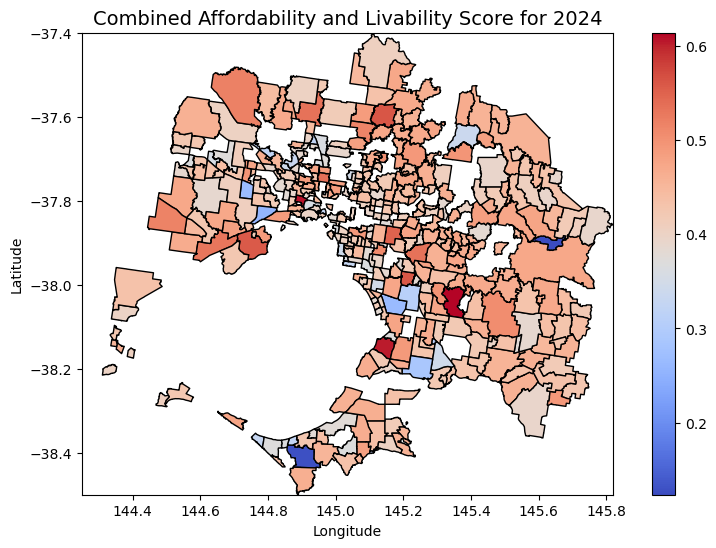

In [29]:
# Merge combined scores back into the GeoDataFrame to get the geometry
plot_data = combined_gdf_year[['SAL_suburb', 'geometry']].merge(
    combined_data[['SAL_suburb', 'combined_score']],
    on='SAL_suburb'
)

# Plot the combined score using GeoPandas
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot combined score using a color map
plot_data.plot(column='combined_score', ax=ax, legend=True,
               cmap='coolwarm', edgecolor='black')

# Set the title and labels
ax.set_title('Combined Affordability and Livability Score for 2024', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the limits for the plot to zoom in on the central region
ax.set_xlim([144.25, 145.82])  # Longitude limits
ax.set_ylim([-38.5, -37.4])    # Latitude limits

# Save the plot as a PNG file
plt.savefig('../../plots/combined_affordability_livability_2024.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [30]:
# Filter for the year you want (e.g., 2024)
year = 2028
combined_gdf_year = combined_gdf[combined_gdf['year'] == year].copy()  # Ensure we are working on a copy

# Initialize the MinMaxScaler for normalization
scaler = MinMaxScaler()

# Define the weights (initially set to 1, can be modified as needed)
weights = {
    'stability': 1,
    'healthcare': 1,
    'culture': 1,
    'education': 1,
    'infrastructure': 1
}

# 1. Stability (Inverted, as lower crime rates are better for stability)
stability_columns = [
    'A Crimes against the person', 'B Property and deception offences',
    'C Drug offences', 'D Public order and security offences',
    'E Justice procedures offences', 'F Other offences'
]
combined_gdf_year.loc[:, 'stability_score'] = 1 - scaler.fit_transform(combined_gdf_year[stability_columns].mean(axis=1).values.reshape(-1, 1))

# 2. Healthcare
combined_gdf_year.loc[:, 'healthcare_score'] = scaler.fit_transform(combined_gdf_year[['healthcare']])

# 3. Culture & Environment
culture_columns = [
    'proximity_to_beach', 'Parks and gardens', 'Natural and semi-natural open space',
    'Civic squares and promenades', 'Recreation corridor', 'Conservation reserves'
]
combined_gdf_year.loc[:, 'culture_score'] = scaler.fit_transform(combined_gdf_year[culture_columns].mean(axis=1).values.reshape(-1, 1))

# 4. Education
education_columns = ['Government schools', 'Non-government schools', 'Tertiary institutions']
combined_gdf_year.loc[:, 'education_score'] = scaler.fit_transform(combined_gdf_year[education_columns].mean(axis=1).values.reshape(-1, 1))

# 5. Infrastructure
infrastructure_columns = ['station_count_in_suburb', 'public_transport', 'shopping', 'recreation']
combined_gdf_year.loc[:, 'infrastructure_score'] = scaler.fit_transform(combined_gdf_year[infrastructure_columns].mean(axis=1).values.reshape(-1, 1))

# Calculate the overall livability score as a weighted average of the normalized scores
combined_gdf_year['livability_score'] = (
    combined_gdf_year['stability_score'] * weights['stability'] +
    combined_gdf_year['healthcare_score'] * weights['healthcare'] +
    combined_gdf_year['culture_score'] * weights['culture'] +
    combined_gdf_year['education_score'] * weights['education'] +
    combined_gdf_year['infrastructure_score'] * weights['infrastructure']
) / sum(weights.values())  # Divide by the total of the weights

# Display the top suburbs by livability score
top_suburbs = combined_gdf_year[['SAL_suburb', 'livability_score']].sort_values(by='livability_score', ascending=False)

# Output the top suburbs by livability score
top_suburbs.head(10)

,SAL_suburb,livability_score
2079,frankston,0.533979
532,berwick,0.489581
2066,footscray,0.463419
1494,dandenong,0.444641
2248,glen waverley,0.427173
4458,rowville,0.413108
1728,doreen,0.400389
1338,craigieburn,0.355198
4237,point cook,0.353143
1247,coburg,0.351460


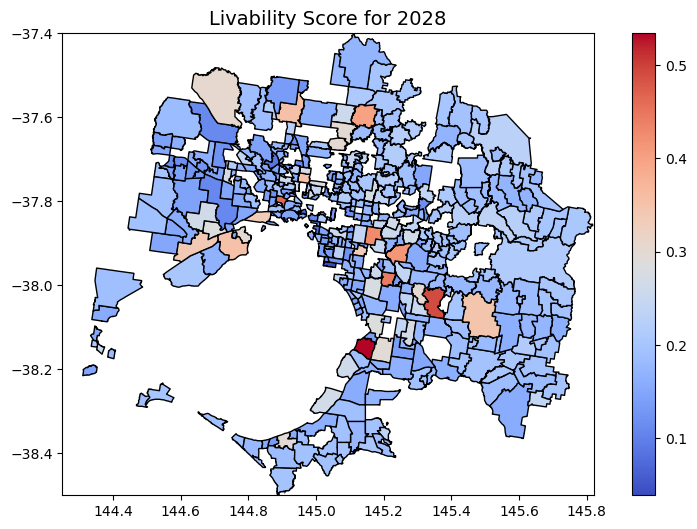

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot the livability score using a color map
combined_gdf_year.plot(column='livability_score', ax=ax, legend=True,
                       cmap='coolwarm', edgecolor='black')

# Set the title and labels
ax.set_title('Livability Score for 2028', fontsize=14)

# Set the limits for the plot to zoom in on the central region
ax.set_xlim([144.25, 145.82])  # Longitude limits
ax.set_ylim([-38.5, -37.4])  # Latitude limits

# Save the plot as a PNG file
plt.savefig('../../plots/livability_2028.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
